In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet_vae import *
from model.retnet.autoencoder_v5_loss_train_vae import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-04 11:14:41.236486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=8,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_backup"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=200, save_dir=stage1_dir, patience=50,kl_warmup_epochs=120)

[Epoch 50] KL weight: 0.0041, KL: 2.6439
[VAE Pretrain] Epoch 50/200 Avg ELBO: -384.5262 (Recon: -387.1701, KLw: 2.6439)
[Epoch 100] KL weight: 0.0083, KL: 5.7109
[VAE Pretrain] Epoch 100/200 Avg ELBO: -459.5882 (Recon: -465.2991, KLw: 5.7109)
[Epoch 150] KL weight: 0.0100, KL: 6.7072
[VAE Pretrain] Epoch 150/200 Avg ELBO: -455.0710 (Recon: -461.7782, KLw: 6.7072)
[Epoch 200] KL weight: 0.0100, KL: 7.1924
[VAE Pretrain] Epoch 200/200 Avg ELBO: -497.5449 (Recon: -504.7374, KLw: 7.1924)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [6]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [7]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=40)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0204
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0202
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0202
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0201
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0202
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0201
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0189
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0188
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0188


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [8]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825
[Joint] Ep1: Calculating global target P...


[Joint] Ep2: Calculating global target P...


[Joint] Ep3: Calculating global target P...


[Joint] Ep4: Calculating global target P...


[Joint] Ep5: Calculating global target P...


[Joint] Ep6: Calculating global target P...


[Joint] Ep7: Calculating global target P...


[Joint] Ep8: Calculating global target P...


[Joint] Ep9: Calculating global target P...


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])
[Joint] Ep11: Calculating global target P...


[Joint] Ep12: Calculating global target P...


[Joint] Ep13: Calculating global target P...


[Joint] Ep14: Calculating global target P...


[Joint] Ep15: Calculating global target P...


[Joint] Ep16: Calculating global target P...


[Joint] Ep17: Calculating global target P...


[Joint] Ep18: Calculating global target P...


[Joint] Ep19: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])
[Joint] Ep21: Calculating global target P...


[Joint] Ep22: Calculating global target P...


[Joint] Ep23: Calculating global target P...


[Joint] Ep24: Calculating global target P...


[Joint] Ep25: Calculating global target P...


[Joint] Ep26: Calculating global target P...


[Joint] Early stopping at epoch 26 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


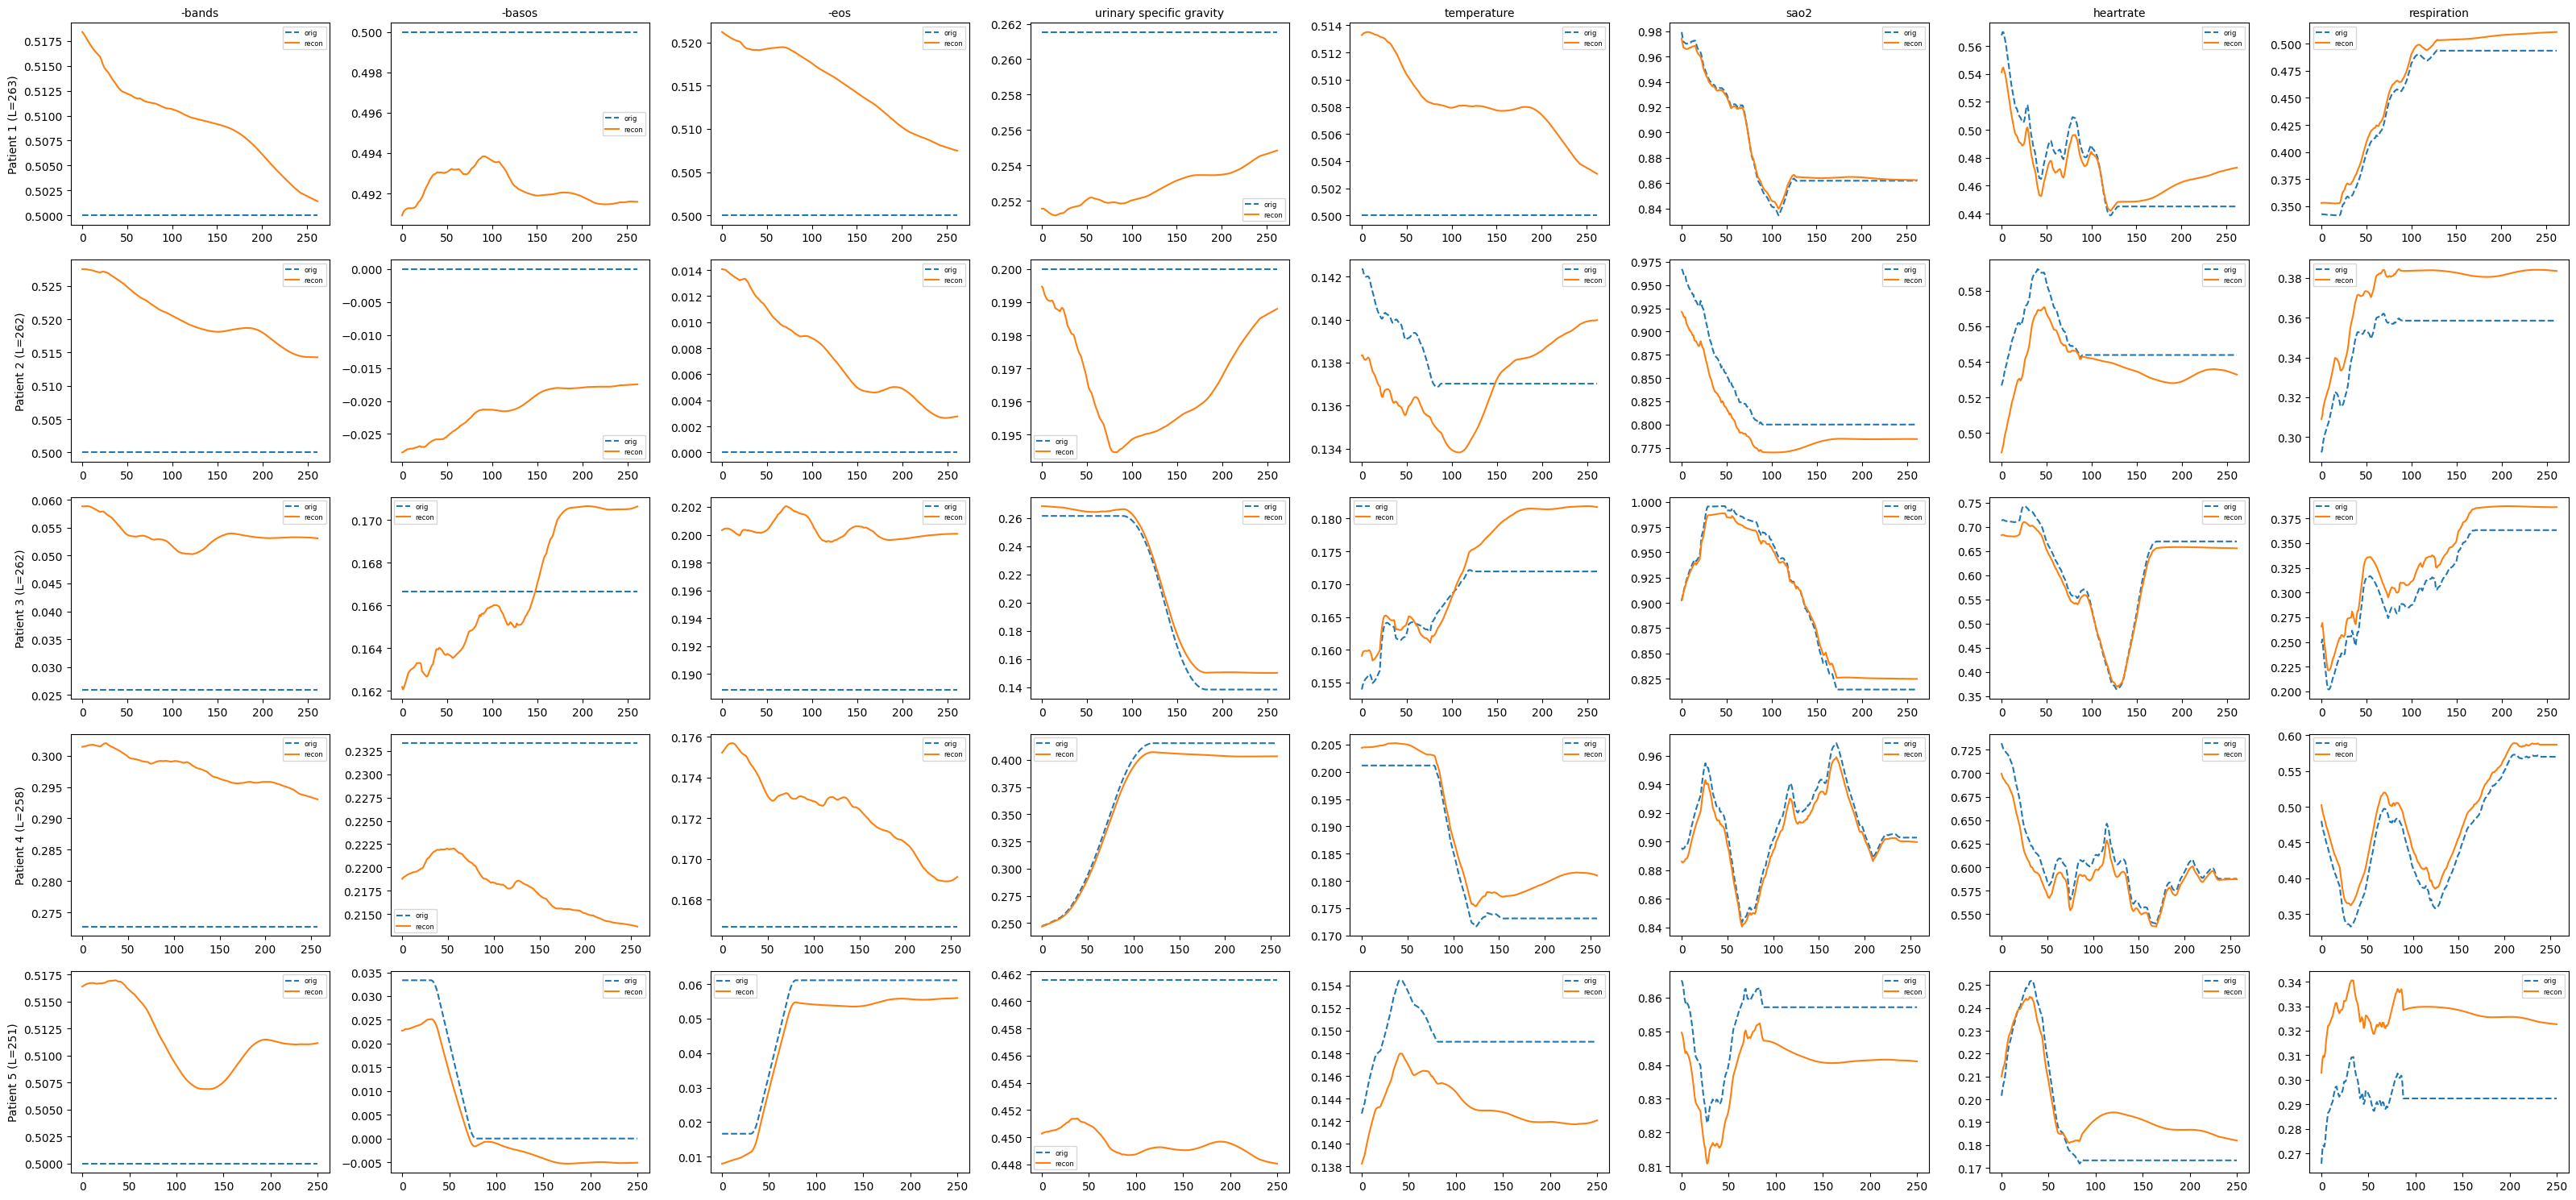

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 77044 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0060
  Std (overall): 0.4913
  Per-dim mean:
tensor([-0.8039,  0.6810, -0.4144,  0.1810,  0.5424, -0.0865, -0.4428, -0.4686,
         0.1052, -1.3625, -0.1268,  0.5688,  0.3193,  0.5241,  0.0979,  0.1188,
        -0.1039,  0.2397, -0.7092,  0.8338,  0.4813, -0.1409,  0.5524, -0.4090,
         1.2534,  0.3532,  0.1342,  0.4564,  0.0576, -0.1973, -0.2770,  0.5364,
        -0.3236,  0.0853,  0.0234, -0.0799, -0.0946, -0.4590, -0.1609,  0.0405,
         0.6426, -0.5090, -0.2544,  0.6727, -0.8221, -0.3276,  0.8936, -0.6026,
        -0.9105, -0.2562,  0.9908, -0.0996, -0.0079,  0.3606, -0.1701, -0.1004,
        -0.6061,  0.0333,  0.2399, -0.1800,  0.4326,  0.4294,  0.0608,  0.4499,
        -0.2087,  0.2337,  0.0084, -0.9618,  1.0115, -0.3323,  0.3569, -0.2548,
         0.2404, -0.1898,  0.1948,  0.2929, -0.2477, -0.0806,  1.3136, -0.1279,
         0.1559,  0.8522, -0.5099,  0.053

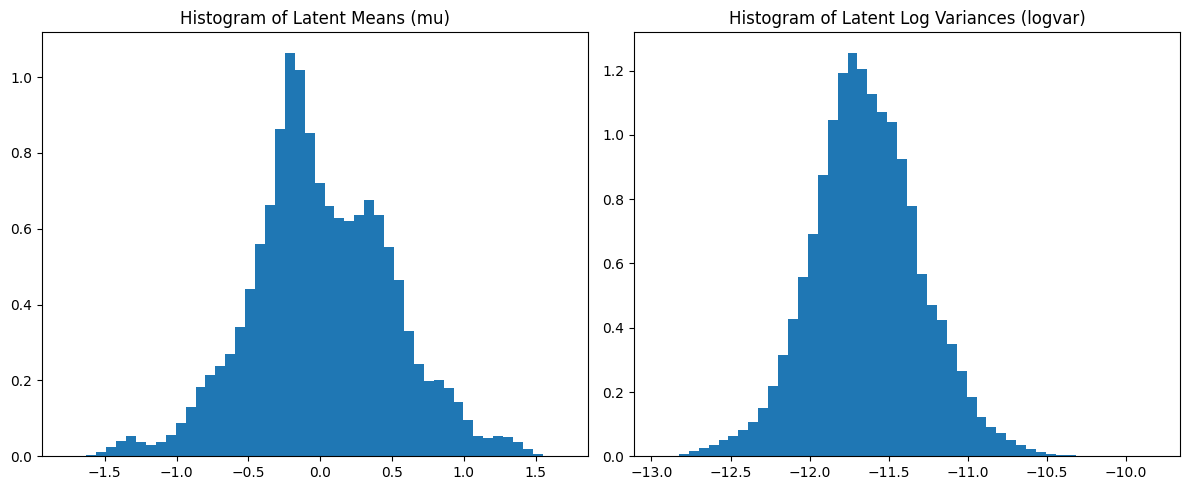

In [10]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar ≈ -11.5（对应 σ² ≈ 1e-5）， 无随机性， kl值过大，与先验不服和

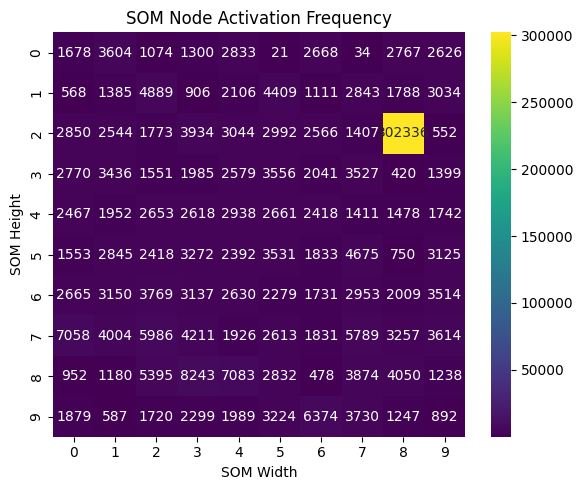

In [11]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

z_all shape: (56596, 128)
y_all shape: (56596,)


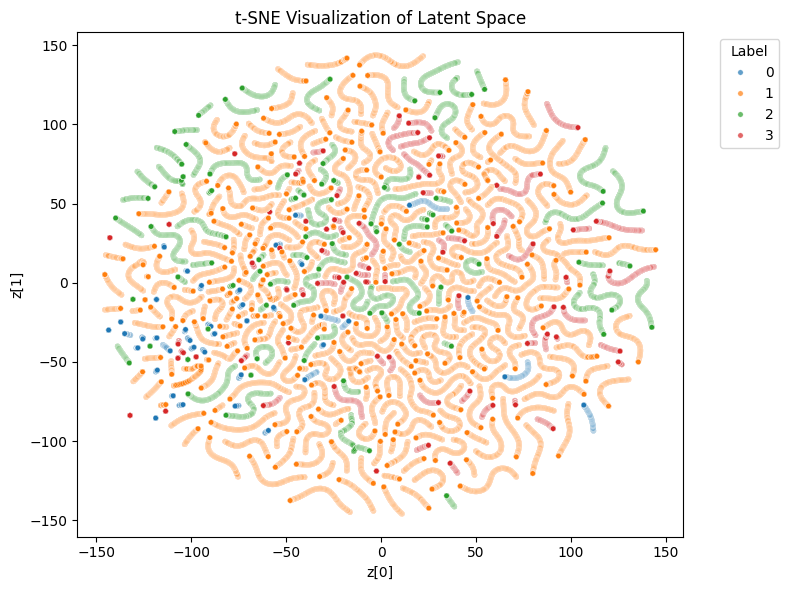

In [12]:
z_all, y_all = collect_latents(model3, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


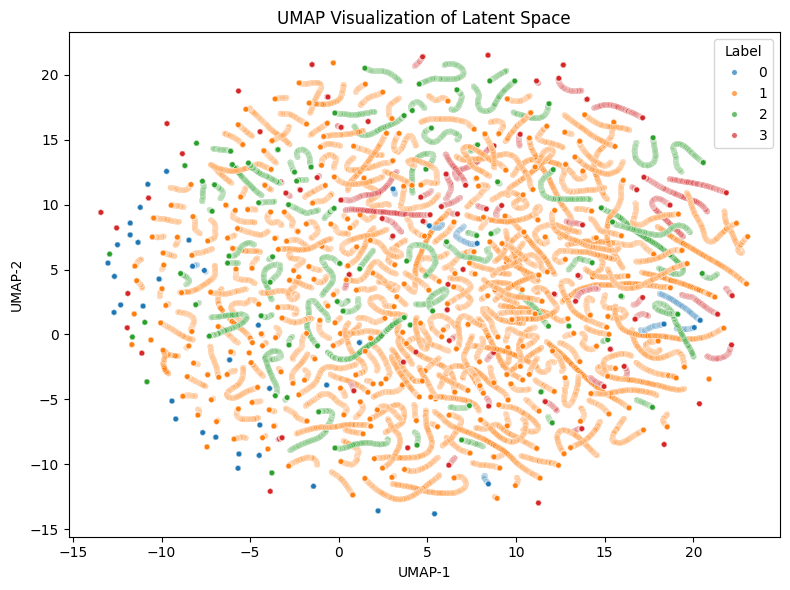

In [13]:
plot_umap(z_all, y_all)